# Final Project
## [Jorge Soler-Lopez](backpackingeconomist.com)

## 0. Introduction

In this paper I try to learn about the different 'trends' in science during the past years. My original idea came from a homework I had to do for my *Public Administration (PA)* course: we had to peruse a bunch of papers from a relevant journal and *identify* the topics according to different criteria. That's when I had the idea: what if we could identify what's 'in' and 'hot' in publishing in the moment using quantitative methods. A mega-meta-analysis of the meta-data, if you will.

The practical implementation requires downloading a good ammount of papers and then running some kind of quantitative method on the whole (or a part) of the paper that would give us a fair idea the topics that are hot. Reading the whole paper would require considerable time and computational resources so I should stick with titles, keywords and abstracts. *Titles* are supposed to good enough to guess a what the paper is about, however, they don't offer a full account of the mathods, data, and other information. Moreover, papers like *Do it now or later*, or *Paying not to go the gym*, barely tell the reader the particular topic. *Keywords* are great for this: they give an accurate account of the topics of the paper in a few words. Many include also the methods used. However, they may be biased by publication and are limited in number. *Abstracts* offer a good way of understanding the paper and most likely include most (if not all) all the keywords. They are probably the best bet in terms of analysis. Finally, *Conclusions* are probably one of the best sources for a synthesis of a paper, however, identifying the conclusion in a written paper can be tricky and innacurate. 

The actual data collection for a project of this magnitude is actually very big. Titles, Keywords, Discipline and Abstract are usually part of the metadata of the papers and can be easily found in any journal page. Moreover, most journal publishers and aggregators offer some kind of API from which bulk download (*harvesting*) is possible:  [Springer](https://dev.springernature.com), [ArXiv](https://arxiv.org). Projects like the Open Archive Iniative ([OAI](https://www.openarchives.org)) offer an standardized way of allowing institutions to have an open data approach to their catalogues.

For the sake of this exercise, however, I will concentrate on the ArXiv, which is a free repository of papers managed by Cornell Univeristy. ArXiv focuses mainly in Physics, Math and Computer Science. But recently it has opened a repository for Economics (From Sept 2017); while Quantitative Finance and Statistics opened in 2007 and 2008, respectively. The [ArXiv API](https://arxiv.org/help/bulk_data) is fairly straighforward (although it uses XML as output), and can be easily imported in Python. Moreover, I will try to accomodate my model so it can show us information on three different disciplines: quantitative finance, quantitative biology, economics, and statistics. A future, more refined model, would be able to discern between sub-disciplines, but I'm starting small.

## 1. Data, Preprocessing, and Annotation (7 pts)

### 1.1. Getting the data aka Harvesting
Special thanks to Tim Head code for this part of the execise. My *harvest3* function is a slightly modified version of his *harvest* function.
Here we will import the necessary libraries and then create a loop for downloading 

In [86]:
import time
import datetime
from collections import Counter, defaultdict
import xml.etree.ElementTree as ET
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import os
import sys
import re
import time
import urllib
import feedparser
import random
from dateutil import parser
from urllib.request import urlretrieve, urlopen
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment','warn')

OAI = "{http://www.openarchives.org/OAI/2.0/}"
ARXIV = "{http://arxiv.org/OAI/arXiv/}"

The harvest function takes in a category (Default is quantitative finance, *q-fin*) and from/to dates in yyyy-mm-dd format. **Note**: The ArXiv API will get upset if we try to download more than 20k item, so try to do the request in batches

In [47]:
def harvest3(arxiv_cat = "q-fin", from_date = "2019-01-01",to_date= "2019-12-31"):
    df = pd.DataFrame(columns=("title", "abstract", "categories", "created", "id", "doi"))
    base_url = "http://export.arxiv.org/oai2?verb=ListRecords&"
    url = (base_url +
           "from=%s&until=%s&metadataPrefix=arXiv&set=%s"%(from_date,to_date,arxiv_cat))
    
    while True:
        print("fetching", url)
        try:
            response = urlopen(url)
            
        except(urllib2.HTTPError, e):
            if e.code == 503:
                to = int(e.hdrs.get("retry-after", 30))
                print("Got 503. Retrying after {0:d} seconds.".format(to))

                time.sleep(to)
                continue
                
            else:
                raise
            
        xml = response.read()

        root = ET.fromstring(xml)

        for record in root.find(OAI+'ListRecords').findall(OAI+"record"):
            arxiv_id = record.find(OAI+'header').find(OAI+'identifier')
            meta = record.find(OAI+'metadata')
            info = meta.find(ARXIV+"arXiv")
            created = info.find(ARXIV+"created").text
            created = datetime.datetime.strptime(created, "%Y-%m-%d")
            categories = info.find(ARXIV+"categories").text

            # if there is more than one DOI use the first one
            # often the second one (if it exists at all) refers
            # to an eratum or similar
            doi = info.find(ARXIV+"doi")
            if doi is not None:
                doi = doi.text.split()[0]
                
            contents = {'title': info.find(ARXIV+"title").text,
                        'id': info.find(ARXIV+"id").text,#arxiv_id.text[4:],
                        'abstract': info.find(ARXIV+"abstract").text.strip(),
                        'created': created,
                        'categories': categories.split(),
                        'doi': doi,
                        }

            df = df.append(contents, ignore_index=True)

        # The list of articles returned by the API comes in chunks of
        # 1000 articles. The presence of a resumptionToken tells us that
        # there is more to be fetched.
        token = root.find(OAI+'ListRecords').find(OAI+"resumptionToken")
        if token is None or token.text is None:
            break

        else:
            url = base_url + "resumptionToken=%s"%(token.text)
            
    return df

In [96]:
fin = harvest3("q-fin","2013-01-01","2020-04-09")
fin['category'] = "q-fin"

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2013-01-01&until=2020-04-09&metadataPrefix=arXiv&set=q-fin
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410437|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410437|2001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410437|3001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410437|4001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410437|5001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410437|6001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410437|7001


In [98]:
econ = harvest3("econ","2017-09-01","2020-04-09")
econ['category'] = "econ"

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2017-09-01&until=2020-04-09&metadataPrefix=arXiv&set=econ
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410439|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410439|2001


In [58]:
# WARNING: Takes a long time
stats = harvest3("stat","2015-09-01","2020-04-09")
stats['category'] = "stats"

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2015-09-01&until=2019-12-31&metadataPrefix=arXiv&set=stat
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|2001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|3001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|4001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|5001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|6001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|7001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|8001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|9001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410324|10001
fetching http://export.arxiv.org/oai2?ver

In [95]:
qbio = harvest3("q-bio","2015-09-01","2020-04-09")
qbio['category'] = "qbio"

fetching http://export.arxiv.org/oai2?verb=ListRecords&from=2015-09-01&until=2020-01-09&metadataPrefix=arXiv&set=q-bio
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|1001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|2001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|3001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|4001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|5001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|6001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|7001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|8001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|9001
fetching http://export.arxiv.org/oai2?verb=ListRecords&resumptionToken=4410425|10001
fetching http://export.arxiv.org/oai2?ve

In [125]:
qbio['category_long'] = "Quantitative Biology"
stats['category_long'] = "Statistics"
econ['category_long'] = "Economics"
fin['category_long'] = "Quantitative Finance"

In [150]:
#Create a big DataFrame with all info
big_df = fin
big_df = big_df.append(econ)
big_df = big_df.append(qbio)
big_df = big_df.append(stats)

In [151]:
df_grouped = big_df.groupby('category_long')

# iterate over each group
for group_name, df_group in df_grouped:
    percentage = len(df_group)*100/len(big_df)
    print(group_name," has", len(df_group), "Papers, or % 5.2f percent of all papers in my corpus."%percentage)

Economics  has 2076 Papers, or  2.73 percent of all papers in my corpus.
Quantitative Biology  has 14039 Papers, or  18.47 percent of all papers in my corpus.
Quantitative Finance  has 7862 Papers, or  10.34 percent of all papers in my corpus.
Statistics  has 52040 Papers, or  68.46 percent of all papers in my corpus.


So we have a fairly large number of papers for Stats (52k!) in comparison to Finance, Econ and Biology. Let save the data somewhere so we don't loose it.

In [169]:
fin.to_pickle('../data/fin.pkl')
econ.to_pickle('../data/econ.pkl')
stats.to_pickle('../data/stats.pkl')
qbio.to_pickle('../data/qbio.pkl')
#To load later df = pd.read_pickle(file_name)

In [153]:
store = pd.HDFStore("../data/save_final.h5") #Requires tables
store['big_df'] = big_df
#df = store['df']
store.close()

In [154]:
len(big_df)

76017

### 1.1. Preparing the data and Some Statistics

Let's clean the data a bit

In [155]:
big_df['Year'] = big_df.created.map(lambda x: x.year) ##Creates the year
big_df = big_df[big_df.Year > 2013] # When we specify the dates, what we download is the edit dates. 
                                    # Meaning that a paper from 1994 edited in 2018, will be in our DB
                                    # We use this to delete such outlayers
print('Total number of papers:', len(big_df))

df_grouped = big_df.groupby('category_long')

#After the cleaning we have
for group_name, df_group in df_grouped:
    percentage = len(df_group)*100/len(big_df)
    print(group_name," has", len(df_group), "Papers, or % 5.2f percent of all papers in my corpus."%percentage)

Total number of papers: 72791
Economics  has 2038 Papers, or  2.80 percent of all papers in my corpus.
Quantitative Biology  has 13390 Papers, or  18.40 percent of all papers in my corpus.
Quantitative Finance  has 6326 Papers, or  8.69 percent of all papers in my corpus.
Statistics  has 51037 Papers, or  70.11 percent of all papers in my corpus.


In [160]:
#Create a nice graph with the number of articles
df_counts = big_df.groupby(['Year', 'category_long']).size().reset_index(name='counts')
df_counts = df_counts[df_counts.Year<2020] # Do not include last year

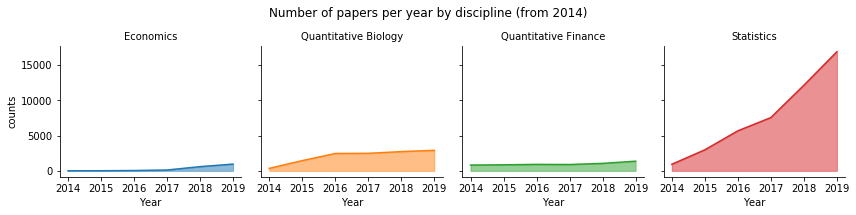

In [162]:
g = sns.FacetGrid(df_counts, col='category_long', hue='category_long', col_wrap=4,)
# Add the line over the area with the plot function
g = g.map(plt.plot, 'Year', 'counts')
# Fill the area with fill_between
g = g.map(plt.fill_between, 'Year', 'counts', alpha=0.5).set_titles("{col_name} Region")
# Titles
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.8)
g = g.fig.suptitle('Number of papers per year by discipline (from 2014)')

It looks like Statstics overshwadows the rest of the disciplines, so let's see the table

In [128]:
df_counts

,Year,category,counts
0,2014,econ,8
1,2014,q-fin,819
2,2014,qbio,349
3,2014,stats,927
4,2015,econ,16
5,2015,q-fin,855
6,2015,qbio,1450
7,2015,stats,2977
8,2016,econ,45
9,2016,q-fin,916


Interesting, all disciplines had increases in the number of papers published every single year.
Now let's see how abstracts behave in term of words:

In [181]:
#For time matters I will delete the stats subject
big_df = big_df[big_df.category != 'stats']

/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


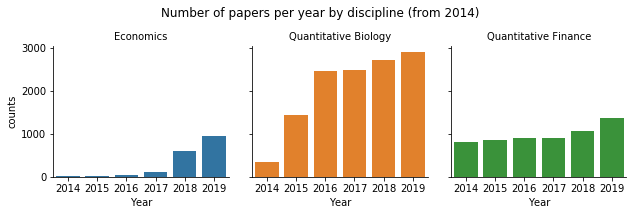

In [285]:
df_counts = big_df.groupby(['Year', 'category_long']).size().reset_index(name='counts')
df_counts = df_counts[df_counts.Year<2020] # Do not include last year
g = sns.FacetGrid(df_counts, col='category_long', hue='category_long', col_wrap=3,)
# Add the line over the area with the plot function
g = g.map(sns.barplot, 'Year', 'counts')
# Titles
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.8)
g = g.fig.suptitle('Number of papers per year by discipline (from 2014)')

Here is clearer that economics just picks up after 2017, when the discipline was created. While for Finance, it seems that for most of the 2010s it was rather flat.
Let's do some text cleaning:

In [163]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [166]:
def clean_text(text):
    '''reduce text to lower-case lexicon entry'''
    lemmas = [token.lemma_ for token in nlp(text) 
              if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN'}]
    return ' '.join(lemmas)

#big_df['clean_abstracts'] = big_df['abstract'].apply(clean_text) #This may take a while

In [168]:
#Let's save our work

store = pd.HDFStore("../data/save_final.h5") #Requires tables
store['big_df'] = big_df
#df = store['df']
store.close()

In [206]:
big_df.clean_abstracts[0]
#The pronouns -PRON- should be deleted
big_df.clean_abstracts = big_df.clean_abstracts.str.replace("-PRON-", "")

Let's see how the number of words in the abstract changes

In [258]:
big_df['absnum'] = big_df['abstract'].str.split().str.len()
big_df['clabsnum'] = big_df['clean_abstracts'].str.split().str.len()

In [264]:
df_abs_size = big_df.groupby(['Year', 'category_long']).absnum.mean().reset_index(name='mean')
df_clabs_size = big_df.groupby(['Year', 'category_long']).clabsnum.mean().reset_index(name='mean')

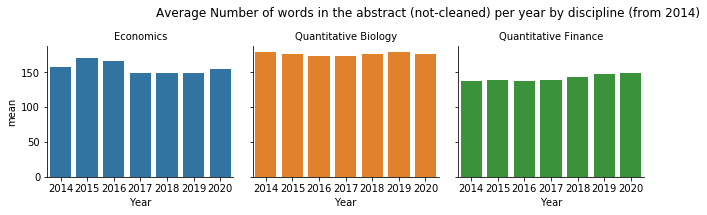

In [267]:
g = sns.FacetGrid(df_abs_size, col='category_long', hue='category_long', col_wrap=3,)
# Add the line over the area with the plot function
g = g.map(sns.barplot, 'Year', 'mean')
# Titles
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.8)
g = g.fig.suptitle('Average Number of words in the abstract (not-cleaned) per year by discipline (from 2014)')

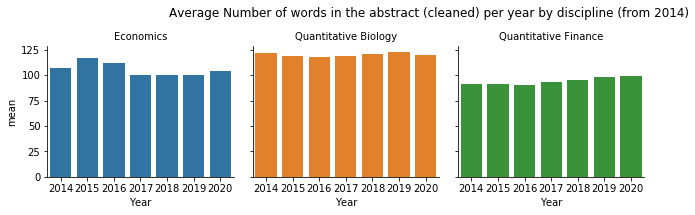

In [266]:
g = sns.FacetGrid(df_clabs_size, col='category_long', hue='category_long', col_wrap=3,)
# Add the line over the area with the plot function
g = g.map(sns.barplot, 'Year', 'mean')
# Fill the area with fill_between
#g = g.map(plt.fill_between, 'Year', 'mean', alpha=0.5).set_titles("{col_name} Region")
# Titles
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.8)
g = g.fig.suptitle('Average Number of words in the abstract (cleaned) per year by discipline (from 2014)')

Here we see a similar size of abstracts, around 150 words for the pre-cleaned abstracts and 100 after.
Now let's see what are the most commong words:

In [207]:
word_bag = " ".join(big_df.abstract.apply(lambda t: t.lower()))
word_bag1 = " ".join(big_df.clean_abstracts.apply(lambda t: t.lower()))
Counter(word_bag.split()).most_common(n=10)

[('the', 230592),
 ('of', 156739),
 ('and', 99661),
 ('a', 85960),
 ('to', 81552),
 ('in', 78583),
 ('we', 52151),
 ('is', 45003),
 ('that', 41228),
 ('for', 40103)]

In [210]:
Counter(word_bag1.split()).most_common(n=10) # This is our cleaned abstracts!

[('be', 97173),
 ('model', 30499),
 ('use', 18689),
 ('that', 16351),
 ('have', 15615),
 ('which', 14683),
 ('can', 14454),
 ('network', 14029),
 ('show', 11684),
 ('time', 11385)]

The first word count includes all words and as such it's straighforward that stopwords appear. In the second, we have cleaned the data using the cleantext function, but still we have some uniformative words appearing. In the analysis part we will continue with the cleaning.

## 2. Research Question

The introduction offers a rationale and a general objective of what I'm looking for with this project. However, since in this exercise I'm doing something smaller, there are two specific research questions that I want to answer here:
1. What are the more important words and topics that characterize a discipline? 
2. Have they change over time?, and if so, can the change be related to what's 'in'? (due to time constrains I won't be able to do this second question, but my idea was to identify topics/words by time period and see if the number of citations change depending on what's 'hot' - For example, if a hot topic in the 2010s was 'financial crisis',  do papers with these topic receive more citations?)

## 3. Analysis
Apply at least one version of *each* of the following analysis methods to the data set (justify your choices):
1. Topic modeling (4 pts). Justify your choice of number of topics!
2. TFIDF analysis (4 pts)

### Other methods
If appropriate for your problem, feel free to explore other methods, as long as they do not require additional libraries (**up to 2 bonus points**).

### 3.1. TFIDF
In this section, we will analyze the words that are more common in the three disciplines. 

We will define a vectorizer using n-grams of 1 to 2 words (to avoid eliminating words like 'future contract'). Moreover, we will use the stop_words option to clean our corpus further.

In [296]:
# This function will give us the results of the TFIDF for any DataFrame. 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def tfidf_analysis(in_df = big_df):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75,
                                   stop_words='english')
    Xone = tfidf_vectorizer.fit_transform(in_df['clean_abstracts'])
    
    vectorizer = CountVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75, 
                             stop_words='english')

    Xtwo = vectorizer.fit_transform(in_df['clean_abstracts'])
    df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': Xtwo.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': Xone.sum(axis=0).A1
                       })
    return df
    
    

In [280]:

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75,
                                   stop_words='english')

X = tfidf_vectorizer.fit_transform(big_df['clean_abstracts'])

In [314]:
df = tfidf_analysis(big_df)

In [325]:
df = df.sort_values(['tfidf', 'tf', 'idf'], ascending = False)

Let's get a bit more analytical and see what happens when we have the 20 most important words by discipline.

In [328]:
df_final = df.head(20).reset_index()

for disc in ["econ","q-fin","qbio"]:
    df = tfidf_analysis(big_df[big_df.category==disc])
    df = df.sort_values(['tfidf', 'tf', 'idf'], ascending = False)
    df_med = df.head(20)
    df_final[disc] = list(df_med['word'])

In [327]:
df_final

,index,word,tf,idf,tfidf,econ,q-fin,qbio
0,6367,model,19308,1.591617,449.305452,model,model,model
1,6902,network,11317,2.284360,367.892383,use,market,network
2,1340,cell,8150,2.686728,308.625420,method,price,cell
3,11254,use,12421,1.622587,288.240298,effect,risk,use
4,2353,datum,7524,2.253286,243.514868,estimator,time,datum
5,6170,method,7367,2.283821,240.963993,datum,use,method
6,8456,protein,4935,3.116487,214.470334,result,problem,protein
7,10808,time,6415,2.292486,211.495967,time,process,time
8,10319,study,7103,2.009643,207.070297,propose,financial,study
9,3073,dynamic,5798,2.384131,203.650596,study,method,dynamic


This final dataframe show us what we were expecting, the column word contains the most important words overall. Much of it being the usual suspects like model, data (datum), results, analysis. However, when we see the other words by discipline, we realize that much of the importance is driven by the relative importance of q-bio in the sample. Notice how economics has as words effect, market and economic; finance has market, price, risk, stock; which don't appear in the overall tfidf analysis.  This part of the exercise is enough to answer Research question 1, but it can be complemented with the next part 'topic modeling'.

### 3.2. Topic Modeling
We will use Latent Dirichlet Allocation to identify sets of words that characterize a topic.

In [377]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [426]:
nlp = spacy.load('en_core_web_sm')
def clean(text):
    return ' '.join([token.lemma_ 
            for token in nlp(text) 
            if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}])
# Clean and remove empty observations
big_df['clean_abstract'] = big_df['abstract'].apply(clean) #Takes a while
big_df = big_df[big_df['clean_abstract'].notnull()]
len(big_df)

21754

# THIS IS NOT WORKING= THE KERNEL FROZE AFTER DOING THESE.IT'S TAKING TOO LONG. I'M NOT EVEN ABLE TO SAVE THE DATAFRAME :(. ONLY THIS SECTION (3.2) IS NOT WORKING, THIS WAS THE LAST THING I DID.


In [441]:

store1 = pd.HDFStore("../data/save_final1.h5") #Requires tables
store1['big_df'] = big_df
#df = store['df']
store.close()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-441-a17a4402f584>", line 1, in <module>
    store1 = pd.HDFStore("../data/save_final1.h5") #Requires tables
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/pandas/io/pytables.py", line 505, in __init__
    self.open(mode=mode, **kwargs)
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/pandas/io/pytables.py", line 627, in open
    self._handle = tables.open_file(self._path, self._mode, **kwargs)
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/tables/file.py", line 315, in open_file
  File "/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/tables/file.py", line 778, in __init__
  File "tables/hdf5extens

HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 444, in H5Fcreate
    unable to create file
  File "H5Fint.c", line 1509, in H5F_open
    unable to open file: time = Fri Apr 10 20:17:19 2020
, name = '../data/save_final1.h5', tent_flags = 13
  File "H5FD.c", line 734, in H5FD_open
    open failed
  File "H5FDsec2.c", line 346, in H5FD_sec2_open
    unable to open file: name = '../data/save_final1.h5', errno = 24, error message = 'Too many open files', flags = 13, o_flags = 602

End of HDF5 error back trace

Unable to open/create file '../data/save_final1.h5'

## 4. Prediction (10 pts)

Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline on the heldout test set (1 point)
2. a `LogisticRegression()` baseline with default parameters on the test set (2 pts)
3. the performance of at least one more predictive model on the test set (4 pts), including description/justification of the optmization steps taken (3 pts). Do make sure that the optimization steps are done on a development split or via cross-validation, and that they do *not* include the test split!

For this part of the exam, I will merge the finance and economics categories into one. That way, I can have a dummy variable and work faster in the problem.

In [334]:
len(big_df)
big_df['m_category'] = big_df['category'].replace(['econ','q-fin'],'econfin')

In [348]:
#I will select approximately 20% of my sample to train the model. 
#By the exercise it's 2000, but since I have more observations I can use the number
big_df['random_numbers'] = np.random.randint(0,4,size=len(big_df))

In [358]:
big_df_t = big_df[big_df.random_numbers==0]
big_df_c = big_df[big_df.random_numbers!=0]

In [359]:
len(big_df_t)
#Total documents to be used for training the model

5390

### 4.1. Text to matrix

In [363]:
from sklearn.preprocessing import LabelEncoder

# transform labels into numbers
labels2numbers = LabelEncoder()

y = labels2numbers.fit_transform(big_df_t['m_category'])

In [369]:
y # 0 = econfinance; 1 = qbiology
print(len(y))

5390


In [365]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.75, 
                             stop_words='english')

X = vectorizer.fit_transform(big_df_t['clean_abstracts'])
print(X.shape)

(5390, 11150)


In [366]:
data_times = vectorizer.vocabulary_['data']
print('The word "data" is repeated %s times in my corpus'%data_times)

The word "data" is repeated 2184 times in my corpus


In [370]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
%time classifier.fit(X, y)
print(classifier)

CPU times: user 730 ms, sys: 49.3 ms, total: 779 ms
Wall time: 267 ms
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [381]:
k = vectorizer.vocabulary_['cell'] # column position for the word
print(vectorizer.get_feature_names()[k], classifier.coef_[0, k])
k = vectorizer.vocabulary_['market'] # column position for the word
print(vectorizer.get_feature_names()[k], classifier.coef_[0, k])

cell 4.1692543328355285
market -6.2129346737811595


Cell has a value of 4.2 and market a value of -6.2. Meaning that the word Cell is a strong predictor of "Biology", while Market is a strong predcitor of "Econ and Finance". Good, our base model seems to be predicting in the right direction. Let's cross-validate our model:

### 4.2. Cross-validation

In [383]:
from sklearn.model_selection import cross_val_score

for k in [2,3,5,10]:
    cv = cross_val_score(LogisticRegression(), X, y=y, cv=k, scoring="f1_micro")
    fold_size = X.shape[0]/k
    
    print("F1 with {} folds for bag-of-words is {}".format(k, cv.mean()))
    print("Training on {} instances/fold, testing on {}".format(fold_size*(k-1), fold_size))
    print()

F1 with 2 folds for bag-of-words is 0.9192949907235621
Training on 2695.0 instances/fold, testing on 2695.0

F1 with 3 folds for bag-of-words is 0.9369093048341313
Training on 3593.3333333333335 instances/fold, testing on 1796.6666666666667

F1 with 5 folds for bag-of-words is 0.9599257884972172
Training on 4312.0 instances/fold, testing on 1078.0

F1 with 10 folds for bag-of-words is 0.9638218923933211
Training on 4851.0 instances/fold, testing on 539.0



In [386]:
from sklearn.dummy import DummyClassifier

most_frequent = DummyClassifier(strategy='most_frequent')

print("Most frequent cross validation is",cross_val_score(most_frequent, X, y=y, cv=k, scoring="f1_micro").mean())

Most frequent cross validation is 0.6153988868274581


Since the most frequent is 0.61, and we are getting .96 with the folding methods, we are doing well, since our model is capable of predicting in-sample much better than simply saying that 61% of our sample is Quantitative Biology (the highest percentage of papers).

### 4.3. Predicting on the held-out data

In [387]:
new_X = vectorizer.transform(big_df_c['clean_abstracts'])
# use the old classifier to predict and evaluate
new_predictions = classifier.predict(new_X)
print(new_predictions)

[0 0 0 ... 1 1 1]


Bonus: I can test the results of the training model in the heldout.

In [394]:
from sklearn.metrics import classification_report
new_y = labels2numbers.transform(big_df_c['m_category'])

print(classification_report(new_y, new_predictions))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      6291
           1       0.96      0.99      0.97     10073

    accuracy                           0.96     16364
   macro avg       0.97      0.96      0.96     16364
weighted avg       0.96      0.96      0.96     16364



Pretty good, almost 97 percent precision out-of-sample.

### 4.4. Selecting a more parsimous model
Now let's do some operations to get a fewer number of features. Let's say 1000

In [401]:
# First let's see which C gives us a better model, cv = 10

from sklearn.metrics import f1_score

best_c = None
best_f1_score = 0.0
for c in [ 20, 10, 1.0, 0.5, 0.1, 0.05, 0.01]:
    clf = LogisticRegression(C=c)
    cv_reg = cross_val_score(clf, X, y=y, cv=10, scoring="f1_micro").mean()

    print("5-CV on train at C={}: {}".format(c, cv_reg.mean()))
    print()

    if cv_reg > best_f1_score:
        best_f1_score = cv_reg
        best_c = c
        
print("best C parameter: {}".format(best_c))

/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


5-CV on train at C=20: 0.9714285714285713

5-CV on train at C=10: 0.9708719851576995

5-CV on train at C=1.0: 0.9638218923933211

5-CV on train at C=0.5: 0.9545454545454545

5-CV on train at C=0.1: 0.8677179962894248

5-CV on train at C=0.05: 0.7807050092764378

5-CV on train at C=0.01: 0.6153988868274581

best C parameter: 20


In [409]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=1000).fit(X, y)
X_sel = selector.transform(X)
print(X_sel.shape)

(5390, 1000)


In [410]:
clf = LogisticRegression(C=best_c)

cv_reg = cross_val_score(clf, X_sel, y=y, cv=10, scoring="f1_micro")
print("10-CV on train: {}".format(cv_reg.mean()))

/Users/Biscotto/opt/anaconda3/envs/MyEnvironment/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


10-CV on train: 0.9727272727272727


Our model is now more parsiminous and without loss of power. Let's see how it predicts vs the actual data.

In [411]:
clf.fit(X_sel, y)

LogisticRegression(C=20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [412]:
# select features for new data
new_X_sel = selector.transform(new_X)

new_predictions_regularized = clf.predict(new_X_sel)

print(classification_report(new_y, new_predictions_regularized))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6291
           1       0.97      0.98      0.98     10073

    accuracy                           0.97     16364
   macro avg       0.97      0.97      0.97     16364
weighted avg       0.97      0.97      0.97     16364



Great. Our model with C=20, using as crossvalidation 10 folds, and 1000 predictors seems to be doing a good job.